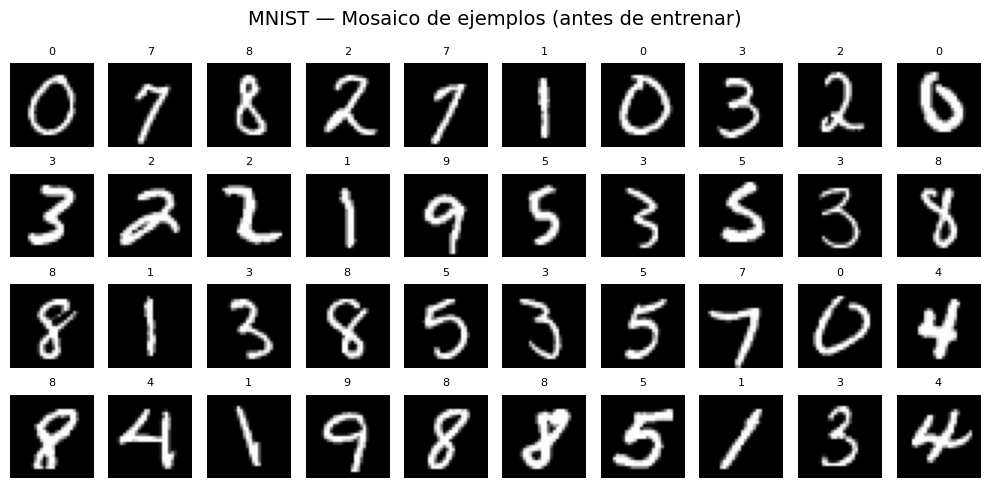

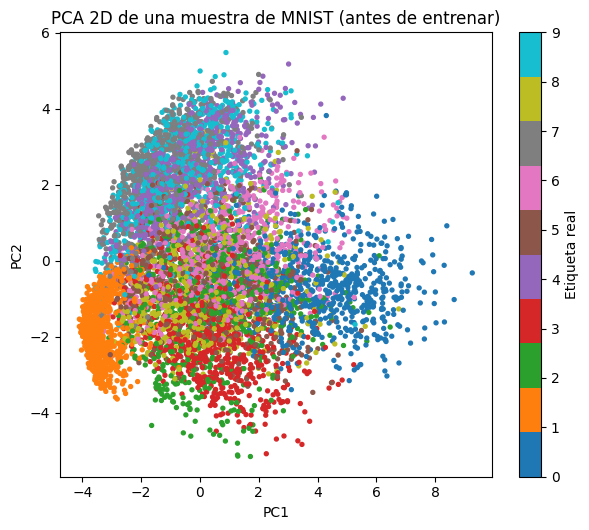

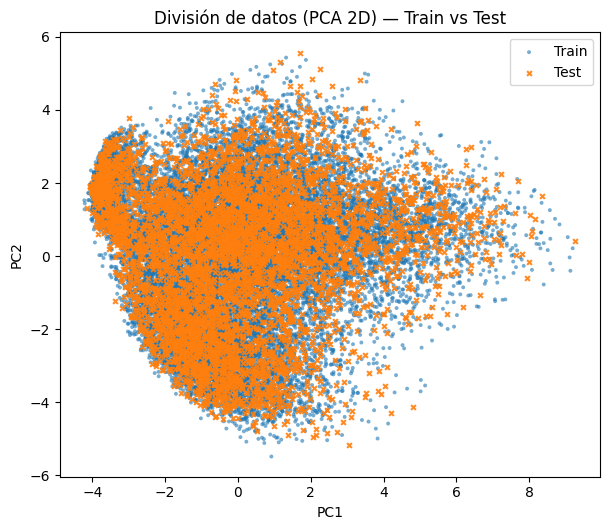

=== Métricas (Test) — MLPClassifier en MNIST ===
Accuracy : 0.9550
Precision: 0.9544 (macro)
Recall   : 0.9546 (macro)
F1-score : 0.9545 (macro)

=== Classification report (por clase) ===
              precision    recall  f1-score   support

           0     0.9679    0.9777    0.9728       493
           1     0.9839    0.9787    0.9813       563
           2     0.9480    0.9499    0.9489       499
           3     0.9363    0.9216    0.9289       510
           4     0.9476    0.9651    0.9563       487
           5     0.9382    0.9424    0.9403       451
           6     0.9694    0.9674    0.9684       491
           7     0.9637    0.9693    0.9665       521
           8     0.9402    0.9344    0.9373       488
           9     0.9492    0.9396    0.9444       497

    accuracy                         0.9550      5000
   macro avg     0.9544    0.9546    0.9545      5000
weighted avg     0.9550    0.9550    0.9550      5000



<Figure size 640x560 with 0 Axes>

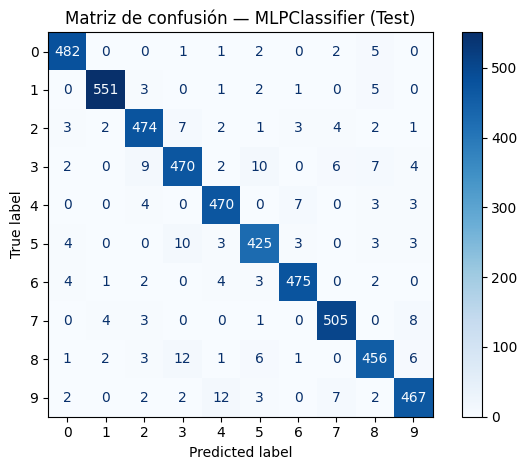

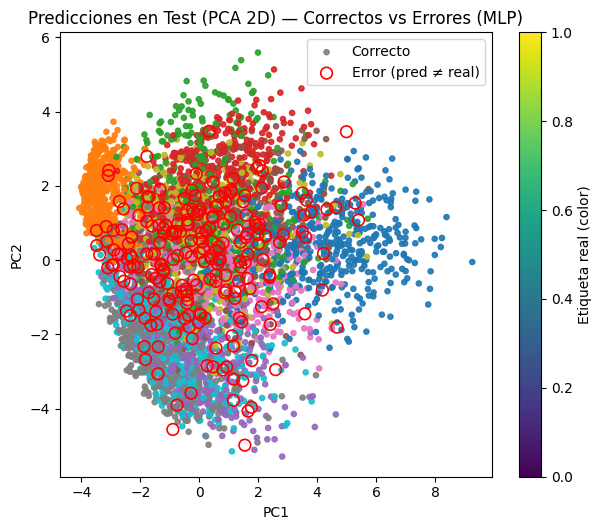

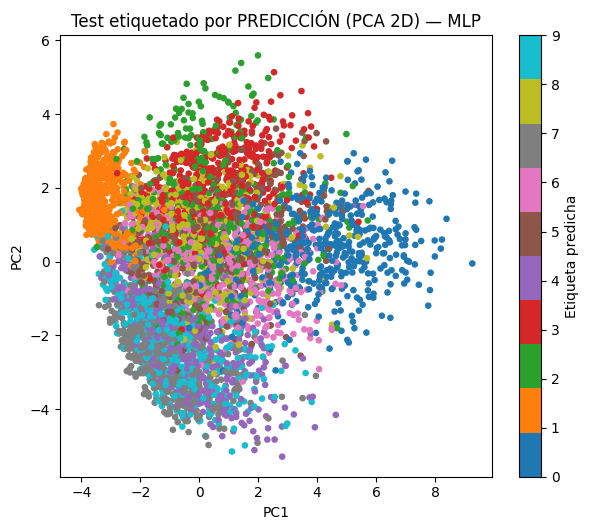

In [2]:
# =========================
# MLPClassifier en MNIST (scikit-learn) — FIX labels int
# =========================
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# ---------- 0) Cargar MNIST ----------
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist.data.astype(np.float32)        # (70000, 784)
y = mnist.target.astype(int)             # <-- FIX: etiquetas como enteros 0..9

# Escalado a [0,1]
X = X / 255.0

# Subconjunto estratificado para rapidez (ajusta si tu PC aguanta más)
N_TRAIN = 20000
N_TEST  = 5000
X_sub, _, y_sub, _ = train_test_split(X, y, train_size=N_TRAIN+N_TEST, stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub, train_size=N_TRAIN, test_size=N_TEST, stratify=y_sub, random_state=42
)

# ---------- 1) Visualización "ANTES" ----------
# 1.1 Mosaico de ejemplos
plt.figure(figsize=(10, 5))
n_show = 40
idx = np.random.RandomState(42).choice(len(X_train), size=n_show, replace=False)
for i, ix in enumerate(idx, 1):
    plt.subplot(4, n_show//4, i)
    plt.imshow(X_train[ix].reshape(28, 28), cmap="gray")
    plt.title(str(y_train[ix]), fontsize=8)
    plt.axis("off")
plt.suptitle("MNIST — Mosaico de ejemplos (antes de entrenar)", fontsize=14)
plt.tight_layout(); plt.show()

# 1.2 PCA 2D del dataset (muestra para rapidez)
pca_all = PCA(n_components=2, random_state=42)
X_all_small = np.vstack([X_train[:5000], X_test[:2500]])
y_all_small = np.hstack([y_train[:5000], y_test[:2500]])
X_pca_all = pca_all.fit_transform(X_all_small)

plt.figure(figsize=(6.2, 5.4))
sc = plt.scatter(X_pca_all[:, 0], X_pca_all[:, 1], c=y_all_small, s=8, cmap="tab10")
plt.title("PCA 2D de una muestra de MNIST (antes de entrenar)")
plt.xlabel("PC1"); plt.ylabel("PC2")
cbar = plt.colorbar(sc, ticks=range(10)); cbar.set_label("Etiqueta real")
plt.tight_layout(); plt.show()

# ---------- 2) División Train/Test en PCA 2D (distinguir la división) ----------
pca_split = PCA(n_components=2, random_state=42)
X_all = np.vstack([X_train, X_test])
y_all = np.hstack([y_train, y_test])
X_pca_split = pca_split.fit_transform(X_all)

mask_train = np.zeros(len(X_all), dtype=bool)
mask_train[:len(X_train)] = True
mask_test = ~mask_train

plt.figure(figsize=(6.2, 5.4))
plt.scatter(X_pca_split[mask_train, 0], X_pca_split[mask_train, 1],
            s=8, alpha=0.6, label="Train", edgecolors='none')
plt.scatter(X_pca_split[mask_test, 0], X_pca_split[mask_test, 1],
            s=12, alpha=0.9, label="Test", marker='x')
plt.title("División de datos (PCA 2D) — Train vs Test")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.tight_layout(); plt.show()

# ---------- 3) Entrenamiento: MLPClassifier ----------
# Estandarizar ayuda al MLP (ahora con dense: usar StandardScaler() por defecto)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=30,              # sube a 60-100 si tu PC lo permite
    early_stopping=True,      # funciona bien ahora que y es int
    n_iter_no_change=5,
    random_state=42,
    verbose=False
)
mlp.fit(X_train_scaled, y_train)

# ---------- 4) Predicciones y métricas ----------
y_pred = mlp.predict(X_test_scaled)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
rec  = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1   = f1_score(y_test, y_pred, average='macro', zero_division=0)

print("=== Métricas (Test) — MLPClassifier en MNIST ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f} (macro)")
print(f"Recall   : {rec:.4f} (macro)")
print(f"F1-score : {f1:.4f} (macro)\n")
print("=== Classification report (por clase) ===")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

# ---------- 5) Matriz de confusión ----------
labels = list(range(10))
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(6.4, 5.6))
disp.plot(cmap="Blues", values_format='d', xticks_rotation=0)
plt.title("Matriz de confusión — MLPClassifier (Test)")
plt.tight_layout(); plt.show()

# ---------- 6) Visualización "DESPUÉS" ----------
# PCA del conjunto de PRUEBA para visualizar correctos vs errores
pca_test = PCA(n_components=2, random_state=42)
X_pca_test = pca_test.fit_transform(X_test)  # solo para graficar

correct = (y_test == y_pred)
plt.figure(figsize=(6.2, 5.4))
# Correctos
plt.scatter(X_pca_test[correct, 0], X_pca_test[correct, 1],
            c=y_test[correct], cmap="tab10", s=14, alpha=0.9, label="Correcto")
# Errores
plt.scatter(X_pca_test[~correct, 0], X_pca_test[~correct, 1],
            facecolors='none', edgecolors='red', s=70, linewidths=1.2, label="Error (pred ≠ real)")
plt.title("Predicciones en Test (PCA 2D) — Correctos vs Errores (MLP)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
cbar = plt.colorbar(); cbar.set_label("Etiqueta real (color)")
plt.tight_layout(); plt.show()

# Otra vista: test coloreado por PREDICCIÓN
plt.figure(figsize=(6.2, 5.4))
sc2 = plt.scatter(X_pca_test[:, 0], X_pca_test[:, 1],
                  c=y_pred, s=14, cmap="tab10")
plt.title("Test etiquetado por PREDICCIÓN (PCA 2D) — MLP")
plt.xlabel("PC1"); plt.ylabel("PC2")
cbar = plt.colorbar(sc2, ticks=range(10)); cbar.set_label("Etiqueta predicha")
plt.tight_layout(); plt.show()


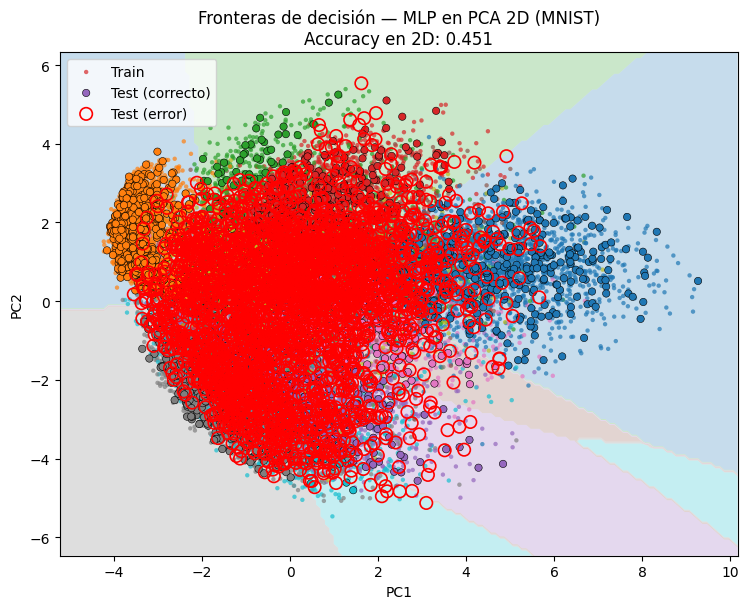

In [3]:
# ---------- 7) Fronteras de decisión en PCA 2D (cómo divide el MLP) ----------
from matplotlib.colors import ListedColormap

# 7.1 Reducimos a 2D con PCA (ajustado SOLO con TRAIN para evitar leakage)
pca_dec = PCA(n_components=2, random_state=42)
X_train_2d = pca_dec.fit_transform(X_train)
X_test_2d  = pca_dec.transform(X_test)

# 7.2 Escalamos las 2D (MLP se beneficia del escalado)
scaler_2d = StandardScaler()
X_train_2d_scaled = scaler_2d.fit_transform(X_train_2d)
X_test_2d_scaled  = scaler_2d.transform(X_test_2d)

# 7.3 Entrenamos un MLP específico en 2D (solo para visualizar fronteras)
mlp_2d = MLPClassifier(
    hidden_layer_sizes=(64,),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    batch_size=256,
    max_iter=60,
    early_stopping=True,
    n_iter_no_change=5,
    random_state=42,
    verbose=False
)
mlp_2d.fit(X_train_2d_scaled, y_train)
y_pred_2d = mlp_2d.predict(X_test_2d_scaled)
acc_2d = accuracy_score(y_test, y_pred_2d)

# 7.4 Malla para pintar regiones de decisión
h = 0.1  # paso de malla
x_min, x_max = X_train_2d[:, 0].min() - 1.0, X_train_2d[:, 0].max() + 1.0
y_min, y_max = X_train_2d[:, 1].min() - 1.0, X_train_2d[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = scaler_2d.transform(grid)
Z = mlp_2d.predict(grid_scaled).reshape(xx.shape)

# 7.5 Plot de fronteras + puntos
cmap_regions = ListedColormap(plt.cm.tab10(np.linspace(0, 1, 10)))
cmap_points  = plt.cm.tab10
correct_2d = (y_test == y_pred_2d)

plt.figure(figsize=(7.6, 6.2))
# Regiones de decisión
plt.contourf(xx, yy, Z, alpha=0.25, cmap=cmap_regions, antialiased=True)

# Puntos TRAIN (coloreados por su clase real)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=cmap_points,
            s=10, alpha=0.7, edgecolors='none', label="Train")

# TEST correctos (borde negro)
plt.scatter(X_test_2d[correct_2d, 0], X_test_2d[correct_2d, 1],
            c=y_test[correct_2d], cmap=cmap_points, s=28,
            edgecolors='k', linewidths=0.4, label="Test (correcto)")

# TEST errores (círculo rojo)
plt.scatter(X_test_2d[~correct_2d, 0], X_test_2d[~correct_2d, 1],
            facecolors='none', edgecolors='red', s=80, linewidths=1.2,
            label="Test (error)")

plt.title(f"Fronteras de decisión — MLP en PCA 2D (MNIST)\nAccuracy en 2D: {acc_2d:.3f}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.xlim(xx.min(), xx.max()); plt.ylim(yy.min(), yy.max())
plt.legend(loc="upper left", frameon=True)
plt.tight_layout(); plt.show()
